# **Data Exploration**

**Let's first explore the train.csv file**

In [1]:
import pandas as pd
import numpy as np

#Reading csv file
data = pd.read_csv('/kaggle/input/face-mask-dataset-wobot/archive/train.csv')

print("Training sample size: ",len(data))
data

Training sample size:  15412


name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]

The above table consists 15412 images. Let's first drop duplicates and check.

In [2]:
data.drop_duplicates(inplace = True)
print("Training sample size after removing duplicates:",len(data))

Training sample size after removing duplicates: 15411


Just one row was duplicate. As there might be multiple detections in an image let's find out how many images are used in training sample & total no. of classes they are classified into.

In [3]:
print("Unique Images: ",len(data.name.unique()))
print("No. of classes: ",len(data.classname.unique()))

Unique Images:  4326
No. of classes:  20


Now let's see the 20 classes.

In [4]:
# Identify different classnames
class_data = data.drop_duplicates(subset = "classname", ignore_index= True)
class_data

name   x1   x2   y1   y2                 classname
0   2756.png   69  126  294  392            face_with_mask
1   2756.png   75  252  264  390             mask_colorful
2   6098.jpg  360   85  728  653              face_no_mask
3   6427.png  218   98  577  580  face_with_mask_incorrect
4   6427.png  278  386  582  582             mask_surgical
5   5392.jpg  261    0  444  257       face_other_covering
6   5392.jpg  261    2  444  257             scarf_bandana
7   4287.png  166  201  592  336                eyeglasses
8   3754.png  354  181  610  337                    helmet
9   3754.png  455  257  629  465               face_shield
10  5342.jpg  377   84  407  107                sunglasses
11  4650.png   55    6  186  133                      hood
12  3939.png   61   65   96  108                       hat
13  2755.png  157  145  416  263                   goggles
14  4538.png    2   41  210  179                  hair_net
15  5725.jpg   84   80  354  403               hijab_niqab
16  5279.jpg  130  177  270  238                     other
17  4047.png  318  169  457  288                  gas_mask
18  4806.png  563    5  653  154        balaclava_ski_mask
19  3309.png  184  174  245  204                    turban

Let's visualise the 20 classes.

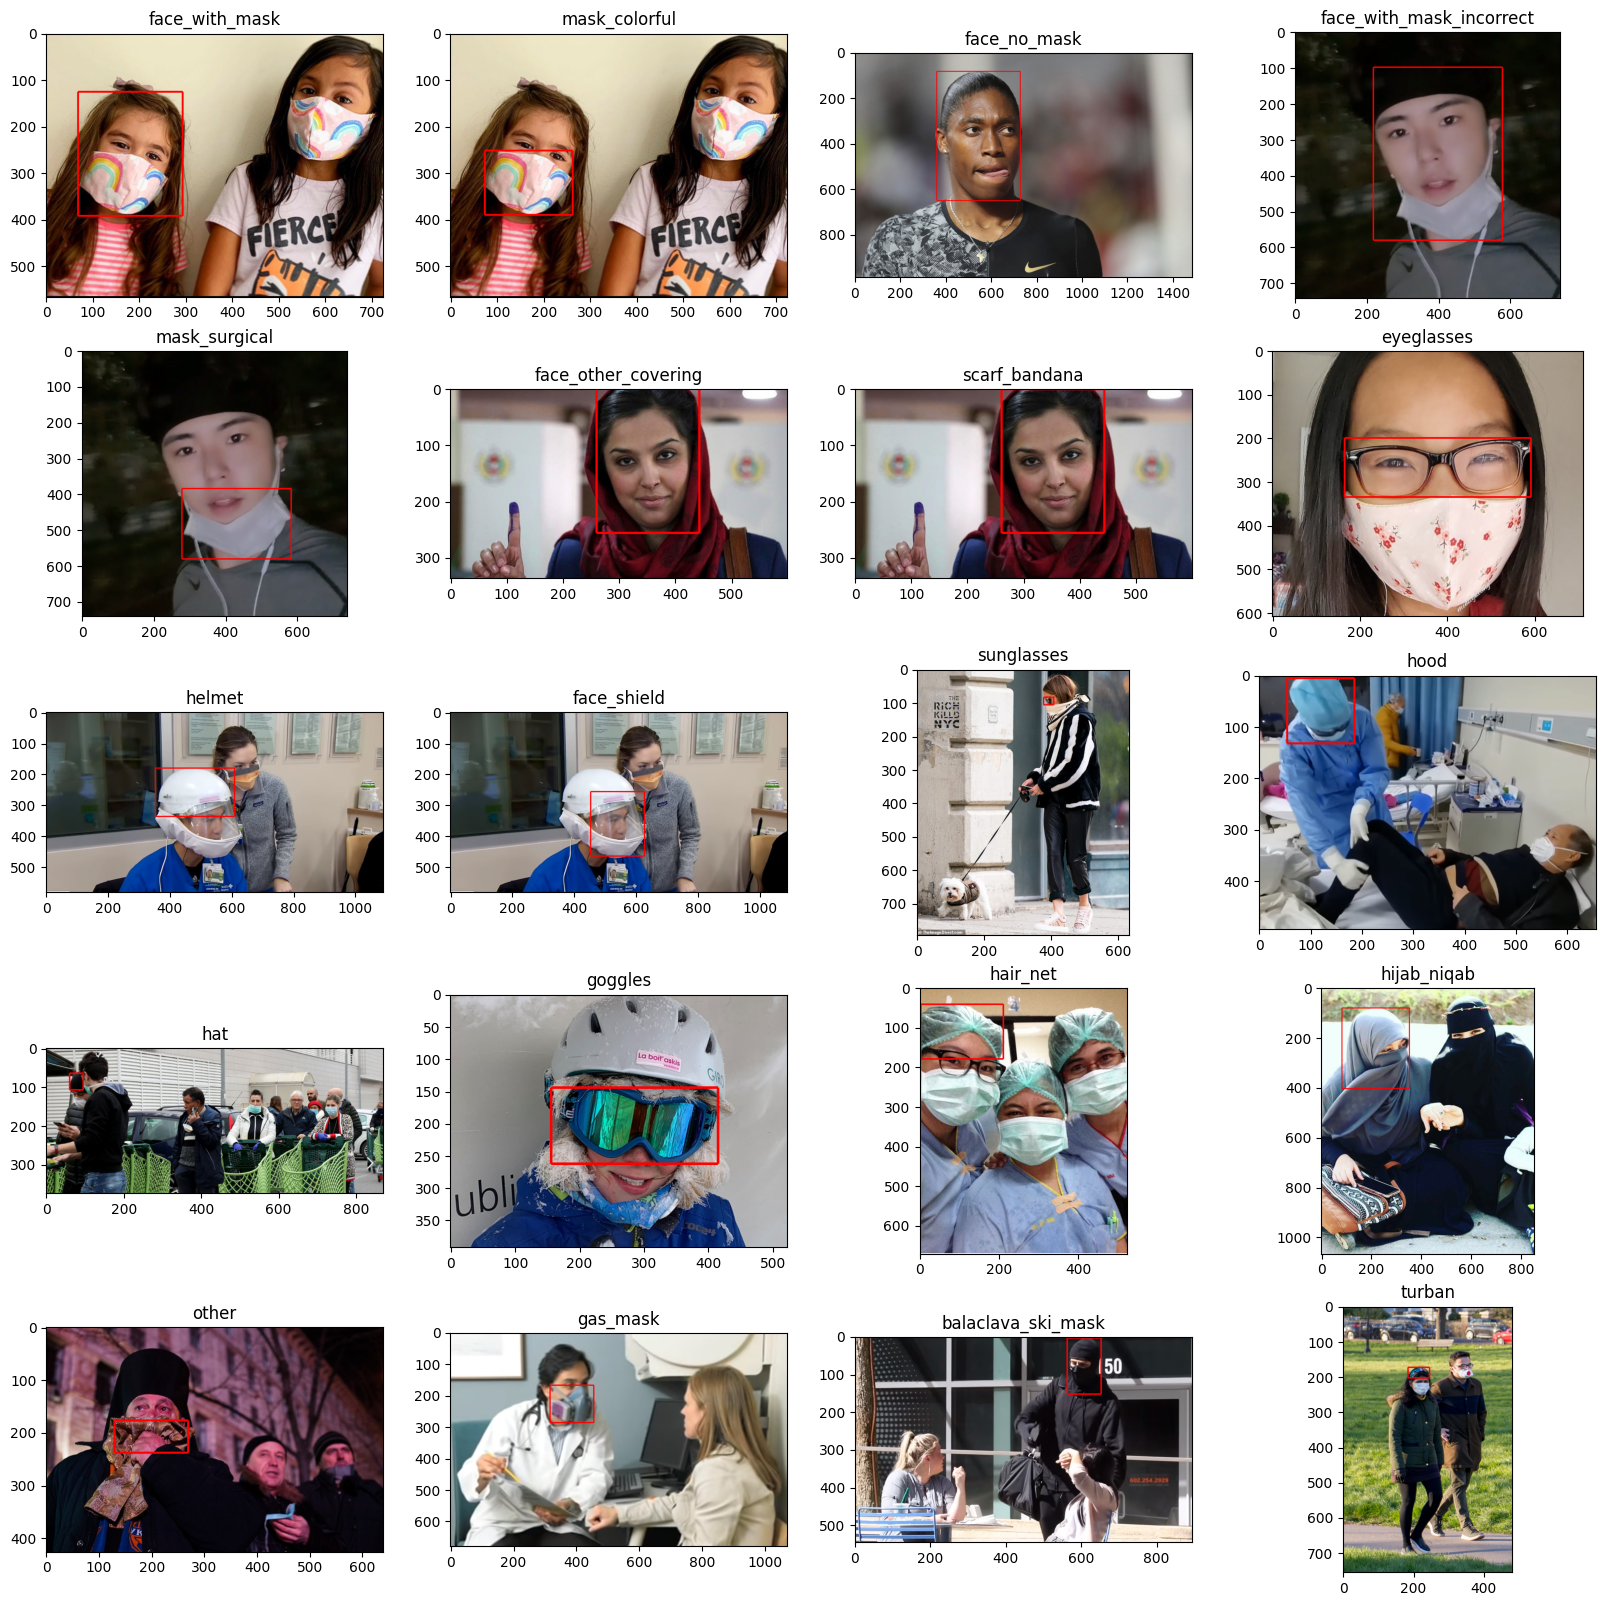

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# function takes image(numpy array), xyxy format coordinates & returns image with bbox
def draw_bbox(image, top_left_x, top_left_y, bot_right_x, bot_right_y):
    image[top_left_y-2 : top_left_y + 2, top_left_x : bot_right_x] = [255,0,0]
    image[bot_right_y-2 : bot_right_y + 2, top_left_x : bot_right_x] = [255,0,0]

    image[top_left_y : bot_right_y, top_left_x - 2 : top_left_x + 2] = [255,0,0]
    image[top_left_y : bot_right_y, bot_right_x - 2 : bot_right_x + 2] = [255,0,0]

    return image

# Dir where images are stored
dir = "/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/"

# Plotting the 20 classes
fig,ax = plt.subplots(5,4, figsize = (20,20))
index = 0
for i in range(5):
    for j in range(4):
        row = class_data.iloc[index]
        path = dir + row["name"]
        image = np.array(Image.open(path))
        detect_image = draw_bbox(image, row["x1"], row["x2"], row["y1"], row["y2"])

        ax[i][j].imshow(detect_image)
        ax[i][j].set_title(row["classname"])

        index += 1


# **Preparing Train and Test data**

We need to detect only two classes(face_with_mask, face_no_mask). Let's collect the rows that have these two classes and see how many samples are there for each.

In [6]:
mask_sample = len(data.query('classname == "face_with_mask"'))
no_mask_sample = len(data.query('classname == "face_no_mask"'))
print("mask_samples: ", mask_sample, "& no_mask_samples: ", no_mask_sample)
new_data = data.query('classname == "face_with_mask" or classname == "face_no_mask"')
new_data

mask_samples:  4180 & no_mask_samples:  1568


name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
4      6098.jpg  360   85  728  653    face_no_mask
7      4591.png  239    9  522  342  face_with_mask
11     5525.jpg  262   18  484  319    face_no_mask
...         ...  ...  ...  ...  ...             ...
15396  4149.png  399   71  718  581  face_with_mask
15399  3389.png  101    2  435  456  face_with_mask
15405  2460.png  650    5  805  184    face_no_mask
15407  1894.jpg  437  121  907  644  face_with_mask
15410  3216.png  126   69  409  463  face_with_mask

[5748 rows x 6 columns]

Assigning class_Id to the classname & prepare label acc. to yolov8

In [7]:
import numpy as np
from PIL import Image

# Renaming the x1, x2, y1, y2
new_data = new_data.rename(columns={'x1': 'top_left_x', 'x2': 'top_left_y', 'y1': 'bot_right_x', 'y2': 'bot_right_y'})

# Assign all id = 1
new_data["class_id"] = 1

# Assigning class_id = 0 to face_no_mask
new_data.loc[new_data["classname"] == "face_no_mask", "class_id"] = 0

# Create the list of paths
dir = "/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/"
path_list = dir + new_data["name"]

# loading image shapes using a list comprehension
image_shape_y = [Image.open(path).size[1] for path in path_list]
image_shape_x = [Image.open(path).size[0] for path in path_list]

# Update the DataFrame with the new column
new_data["image_shape_x"] = image_shape_x
new_data["image_shape_y"] = image_shape_y

# coordinates for yolo labels
new_data["width"] = (new_data["bot_right_x"] - new_data["top_left_x"])
new_data["height"] = (new_data["bot_right_y"] - new_data["top_left_y"])
new_data["center_x"] = (new_data["top_left_x"] + (new_data["width"]//2))
new_data["center_y"] = (new_data["top_left_y"] + (new_data["height"]//2))

# Normalising labels
new_data["width"] = new_data["width"]/image_shape_x
new_data["height"] = new_data["height"]/image_shape_y
new_data["center_x"] = new_data["center_x"]/image_shape_x
new_data["center_y"] = new_data["center_y"]/image_shape_y

new_data

name  top_left_x  top_left_y  bot_right_x  bot_right_y  \
0      2756.png          69         126          294          392   
1      2756.png         505          10          723          283   
4      6098.jpg         360          85          728          653   
7      4591.png         239           9          522          342   
11     5525.jpg         262          18          484          319   
...         ...         ...         ...          ...          ...   
15396  4149.png         399          71          718          581   
15399  3389.png         101           2          435          456   
15405  2460.png         650           5          805          184   
15407  1894.jpg         437         121          907          644   
15410  3216.png         126          69          409          463   

            classname  class_id  image_shape_x  image_shape_y     width  \
0      face_with_mask         1            725            566  0.310345   
1      face_with_mask         1            725            566  0.300690   
4        face_no_mask         0           1484            989  0.247978   
7      face_with_mask         1            776            519  0.364691   
11       face_no_mask         0            615            409  0.360976   
...               ...       ...            ...            ...       ...   
15396  face_with_mask         1            728            621  0.438187   
15399  face_with_mask         1            527            671  0.633776   
15405    face_no_mask         0           1018            541  0.152259   
15407  face_with_mask         1           1280            720  0.367188   
15410  face_with_mask         1            530            670  0.533962   

         height  center_x  center_y  
0      0.469965  0.249655  0.457597  
1      0.482332  0.846897  0.257951  
4      0.574317  0.366577  0.373104  
7      0.641618  0.489691  0.337187  
11     0.735941  0.606504  0.410758  
...         ...       ...       ...  
15396  0.821256  0.766484  0.524960  
15399  0.676602  0.508539  0.341282  
15405  0.330869  0.714145  0.173752  
15407  0.726389  0.525000  0.530556  
15410  0.588060  0.503774  0.397015  

[5748 rows x 13 columns]

**Train-Test split**

Let's split data in 4:1.


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_data["name"],new_data[["class_id", "center_x", "center_y", "width", "height"]] ,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

train_data = x_train.to_frame().merge(y_train, left_index=True, right_index=True)
test_data = x_test.to_frame().merge(y_test, left_index=True, right_index=True)

mask_sample_train = len(train_data.query('class_id == 1'))
no_mask_sample_train = len(train_data.query('class_id == 0'))

mask_sample_test = len(test_data.query('class_id == 1'))
no_mask_sample_test = len(test_data.query('class_id == 0'))


print("Train:   mask_samples: ", mask_sample_train, "& no_mask_samples: ", no_mask_sample_train)
print("========================================")
train_data.head()

Train:   mask_samples:  3360 & no_mask_samples:  1238


name  class_id  center_x  center_y     width    height
13621  5999.jpg         0  0.185547  0.143229  0.226562  0.281250
5800   4813.png         1  0.819066  0.450394  0.198444  0.359055
7571   1837.jpg         1  0.249008  0.549425  0.136905  0.363218
7290   2909.png         1  0.691358  0.427419  0.290809  0.488710
1645   5994.jpg         0  0.425562  0.350000  0.433989  0.666667

In [9]:
print("Test:   mask_samples: ", mask_sample_test, "& no_mask_samples: ", no_mask_sample_test)
print("========================================")
test_data.head()

Test:   mask_samples:  820 & no_mask_samples:  330


name  class_id  center_x  center_y     width    height
11033  5619.jpg         1  0.425847  0.169492  0.075212  0.190207
2451   5608.jpg         0  0.614706  0.405000  0.348529  0.780000
15013  4141.png         1  0.768129  0.192708  0.047449  0.119792
12602  5013.jpg         1  0.510000  0.273846  0.077500  0.152308
11537  4994.jpg         1  0.266922  0.452107  0.494253  0.496169

**Creating train, test Folder for ultralytics YOLO**

In [10]:
import os
import shutil

# Source path
src_path = "/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/"

# removing dir. if already exist
if(os.path.exists('/kaggle/working/train/')):
    shutil.rmtree('/kaggle/working/train')

if(os.path.exists('/content/working/test/')):
    shutil.rmtree('/kaggle/working/test')

os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/test')

os.mkdir('/kaggle/working/train/images')
os.mkdir('/kaggle/working/train/labels')

os.mkdir('/kaggle/working/test/images')
os.mkdir('/kaggle/working/test/labels')

# Function for creating label(txt file) and image folder for train & test
def create_image_label(img_name, class_id, center_x, center_y, width, height, train = 1):
    
    # find whether (jpg,png) or jpeg
    if(img_name[-5] == '.'):
        pos = -5
    else:
        pos = -4

    # txt file with same name
    name = img_name[0:pos] + '.txt'

    # whether labeling for train or test set
    if(train):
        path_label = '/kaggle/working/train/labels/'
        path_image = '/kaggle/working/train/images/'
    else:
        path_label = '/kaggle/working/test/labels/'
        path_image = '/kaggle/working/test/images/'

    # copy image to test/train dir
    if(os.path.exists(path_image + img_name) == False):
        shutil.copyfile(src_path + img_name, path_image + img_name)

    # Write or append in label file
    if(os.path.exists(path_label + name)):
        with open(path_label + name, 'a') as file:
            file.write('\n'+" ".join(map(str, [class_id, center_x, center_y, width, height])))
    else:
        with open(path_label + name, 'w') as file:
            file.write(" ".join(map(str, [class_id, center_x, center_y, width, height])))

# Create train folder
train_data.apply(lambda row: create_image_label(row["name"], row["class_id"], row["center_x"],
                                                row["center_y"], row["width"], row["height"]), axis = 1);
# Create test folder
test_data.apply(lambda row: create_image_label(row["name"], row["class_id"], row["center_x"],
                                                row["center_y"], row["width"], row["height"], train = 0), axis = 1);

# **Training**

**Installing ultralytics & importing YOLO**

In [11]:
!pip install ultralytics

from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt') # pre-trained model;


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 14.1 MB/s eta 0:00:00a 0:00:01


100%|██████████| 6.23M/6.23M [00:00<00:00, 75.3MB/s]


**Setting up Config.yaml file for train, test location**

In [12]:
with open('/kaggle/working/config.yaml', 'w') as file:
    file.write("train: /kaggle/working/train" + '\n' + 
               "val: /kaggle/working/test" + '\n' + 
               "names: " + '\n' + 
                "  " + "0: face_no_mask" + '\n' +
                "  " + "1: face_with_mask")

**Training the model**

In [13]:
!pip install wandb

In [14]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
results = model.train(data="/kaggle/working/config.yaml", epochs=50, device = [0,1])

Ultralytics YOLOv8.2.26 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/config.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=F

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-05-30 13:54:16,740	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-30 13:54:17,487	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Currently logged in as: tusharsadhwani03 (opn_ai). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240530_135438-rvziwxkd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/opn_ai/YOLOv8
wandb: 🚀 View run at https://wandb.ai/opn_ai/YOLOv8/runs/rvziwxkd


Overriding model.yaml nc=80 with nc=2
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 2926 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2926/2926 [00:09<00:00, 314.50it/s] 


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/test/labels... 965 images, 0 backgrounds, 0 corrupt: 100%|██████████| 965/965 [00:02<00:00, 423.88it/s]


val: New cache created: /kaggle/working/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.27G      1.097      2.106      1.233         22        640: 100%|██████████| 183/183 [00:51<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:16<00:00,  3.81it/s]


                   all        965       1152       0.49      0.722      0.522      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.22G       1.05       1.39      1.181         19        640: 100%|██████████| 183/183 [00:48<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.50it/s]


                   all        965       1152      0.427      0.763      0.495      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.21G      1.054      1.233      1.178         23        640: 100%|██████████| 183/183 [00:46<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.75it/s]


                   all        965       1152      0.468      0.699      0.491      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.21G      1.058      1.131      1.181         12        640: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


                   all        965       1152      0.463      0.762      0.464       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.21G      1.027      1.034      1.166         19        640: 100%|██████████| 183/183 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.45it/s]


                   all        965       1152      0.467      0.801      0.558      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.21G      1.024     0.9828      1.161         25        640: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.58it/s]


                   all        965       1152      0.471      0.788      0.521      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.21G     0.9868     0.9163      1.148         16        640: 100%|██████████| 183/183 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.59it/s]


                   all        965       1152      0.481      0.765      0.554      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.21G      1.009     0.9069      1.157         17        640: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.51it/s]


                   all        965       1152        0.5      0.755      0.589      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.22G      0.974     0.8615      1.136         22        640: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.44it/s]


                   all        965       1152      0.475      0.809      0.567      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.21G     0.9782      0.842      1.139         24        640: 100%|██████████| 183/183 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.57it/s]


                   all        965       1152      0.479        0.8      0.557      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.21G     0.9755     0.8143      1.144         19        640: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.55it/s]


                   all        965       1152      0.464      0.773      0.529      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.21G      0.955     0.7807      1.133         27        640: 100%|██████████| 183/183 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.39it/s]


                   all        965       1152      0.479        0.8      0.568      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.21G     0.9594     0.7901       1.12         26        640: 100%|██████████| 183/183 [00:48<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.28it/s]


                   all        965       1152      0.462      0.823      0.542      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.21G     0.9571     0.7947      1.123         12        640: 100%|██████████| 183/183 [00:48<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.24it/s]


                   all        965       1152      0.479      0.801      0.568      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.21G     0.9279      0.745      1.112         21        640: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


                   all        965       1152      0.468      0.821      0.584       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.21G     0.9335     0.7505      1.101         18        640: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


                   all        965       1152      0.496      0.766      0.588      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.2G     0.9224      0.733      1.101         23        640: 100%|██████████| 183/183 [00:46<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.50it/s]


                   all        965       1152      0.468      0.823      0.586       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.21G     0.9313     0.7402      1.113         37        640: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.55it/s]


                   all        965       1152      0.461      0.793       0.62      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.21G     0.8973     0.7181        1.1         18        640: 100%|██████████| 183/183 [00:48<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


                   all        965       1152       0.49      0.767       0.56      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.21G      0.899     0.6981      1.083         23        640: 100%|██████████| 183/183 [00:47<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.71it/s]


                   all        965       1152      0.475      0.808      0.616      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.21G     0.9056      0.716        1.1         23        640: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.68it/s]


                   all        965       1152      0.467      0.826      0.616      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       1.2G     0.9014     0.7082      1.094         14        640: 100%|██████████| 183/183 [00:47<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.63it/s]


                   all        965       1152      0.448      0.838      0.549      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.21G     0.8925     0.6762       1.09         16        640: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.58it/s]


                   all        965       1152      0.444      0.843      0.552       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       1.2G     0.9017     0.6962      1.101         21        640: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.39it/s]


                   all        965       1152      0.454      0.841      0.633      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       1.2G     0.8691      0.667      1.072         18        640: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.36it/s]


                   all        965       1152      0.457      0.809      0.581      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       1.2G     0.8714     0.6622      1.069         20        640: 100%|██████████| 183/183 [00:47<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.41it/s]


                   all        965       1152       0.46      0.826      0.568      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.21G     0.8708     0.6632      1.076         21        640: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.22it/s]


                   all        965       1152       0.45      0.857      0.631      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.21G     0.8763     0.6731      1.076         15        640: 100%|██████████| 183/183 [00:47<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.36it/s]


                   all        965       1152      0.454      0.848      0.596      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       1.2G     0.8466     0.6277      1.064         28        640: 100%|██████████| 183/183 [00:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.57it/s]


                   all        965       1152      0.453      0.854      0.619      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.21G     0.8506     0.6169      1.071         19        640: 100%|██████████| 183/183 [00:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.69it/s]


                   all        965       1152      0.436      0.856      0.593      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.21G     0.8367     0.6147       1.06         20        640: 100%|██████████| 183/183 [00:46<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.74it/s]


                   all        965       1152      0.435       0.88      0.565      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.21G     0.8615     0.6192      1.072         23        640: 100%|██████████| 183/183 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.63it/s]


                   all        965       1152      0.439      0.836      0.543      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       1.2G      0.843     0.6274      1.062         25        640: 100%|██████████| 183/183 [00:47<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


                   all        965       1152      0.439      0.818      0.583       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       1.2G     0.8285     0.5937      1.052         19        640: 100%|██████████| 183/183 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.51it/s]


                   all        965       1152      0.434      0.858       0.59      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.21G     0.8105     0.5907      1.051         30        640: 100%|██████████| 183/183 [00:47<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.49it/s]


                   all        965       1152       0.43       0.83      0.583      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.21G     0.8363     0.5963      1.065         24        640: 100%|██████████| 183/183 [00:47<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.61it/s]


                   all        965       1152      0.425      0.877      0.541       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.21G     0.8235     0.5993      1.061         21        640: 100%|██████████| 183/183 [00:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.62it/s]


                   all        965       1152      0.441      0.857      0.559      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.21G      0.811      0.581      1.058         17        640: 100%|██████████| 183/183 [00:46<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


                   all        965       1152      0.439      0.876       0.56      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       1.2G     0.8051     0.5797      1.055         17        640: 100%|██████████| 183/183 [00:46<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.43it/s]


                   all        965       1152      0.439      0.823      0.581       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.21G     0.7845       0.58      1.038         14        640: 100%|██████████| 183/183 [00:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.48it/s]


                   all        965       1152      0.422      0.875      0.569      0.433
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.34G     0.7463     0.4828      1.014         12        640: 100%|██████████| 183/183 [00:46<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.62it/s]


                   all        965       1152      0.427      0.872       0.56      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.21G     0.7253     0.4655     0.9991         12        640: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.73it/s]


                   all        965       1152      0.423      0.863      0.534        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.22G     0.7328     0.4616     0.9913          7        640: 100%|██████████| 183/183 [00:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.60it/s]


                   all        965       1152      0.416      0.848      0.542       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       1.2G     0.7116     0.4505     0.9939         15        640: 100%|██████████| 183/183 [00:46<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.68it/s]


                   all        965       1152      0.421      0.861      0.556      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.21G     0.7213     0.4483     0.9861         13        640: 100%|██████████| 183/183 [00:45<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.66it/s]


                   all        965       1152       0.42      0.848      0.559      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       1.2G     0.7191     0.4518     0.9838          8        640: 100%|██████████| 183/183 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.52it/s]


                   all        965       1152       0.42      0.852      0.541      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.21G     0.7063     0.4369     0.9868         15        640: 100%|██████████| 183/183 [00:44<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.58it/s]


                   all        965       1152      0.418      0.839      0.538      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       1.2G     0.6994     0.4276     0.9882         13        640: 100%|██████████| 183/183 [00:45<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.46it/s]


                   all        965       1152      0.415      0.834      0.547      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.21G     0.6941      0.429     0.9786         12        640: 100%|██████████| 183/183 [00:44<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:12<00:00,  4.70it/s]


                   all        965       1152      0.422      0.829      0.545      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.21G     0.6926     0.4278     0.9736          9        640: 100%|██████████| 183/183 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.60it/s]


                   all        965       1152      0.419      0.825      0.534      0.406

50 epochs completed in 0.856 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:14<00:00,  4.31it/s]


                   all        965       1152      0.455      0.839      0.633      0.478
          face_no_mask        283        332      0.439      0.771      0.604      0.467
        face_with_mask        705        820       0.47      0.906      0.662      0.488
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▃▂▂▁▃▅▆▅▄▅▄▅▆▆▇▅▇▄▅█▅█▆▇▅▄▆▆▄▅▅▆▅▄▄▅▄▄▄█
wandb:     metrics/mAP50-95(B) ▃▂▂▁▃▅▅▅▄▅▄▅▆▆▇▅▇▅▅█▆█▇▇▆▅▆▇▅▆▆▆▆▅▅▅▅▅▅█
wandb:    metrics/precision(B) ▇▂▅▅▆▆█▆▅▆▅▆█▅▅▇▅▄▃▄▅▄▄▄▃▃▃▃▂▃▃▃▂▂▁▂▁▁▁▄
wandb:       metrics/recall(B) ▂▃▁▃▄▄▃▅▄��▆▅▄▆▅▄▆▆▇▇▆▇▇▇█▆▆▇█▇█▆█▇▇▇▇▆▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁
wandb:          train/cls_loss █▅▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▇▇▇▆▆▆▅▆▅▅▅▄▄▅▄▄▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▁▂▁▁▁▁
wandb:            val/box_loss ▆▇█▇▆▅▆▅▅▄▃▄▃▄▃▂▃▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂

In [17]:
res = model.predict('/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/0012.jpg', save = True)


image 1/1 /kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/0012.jpg: 448x640 2 face_no_masks, 2 face_with_masks, 66.7ms
Speed: 2.7ms preprocess, 66.7ms inference, 1253.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/train2


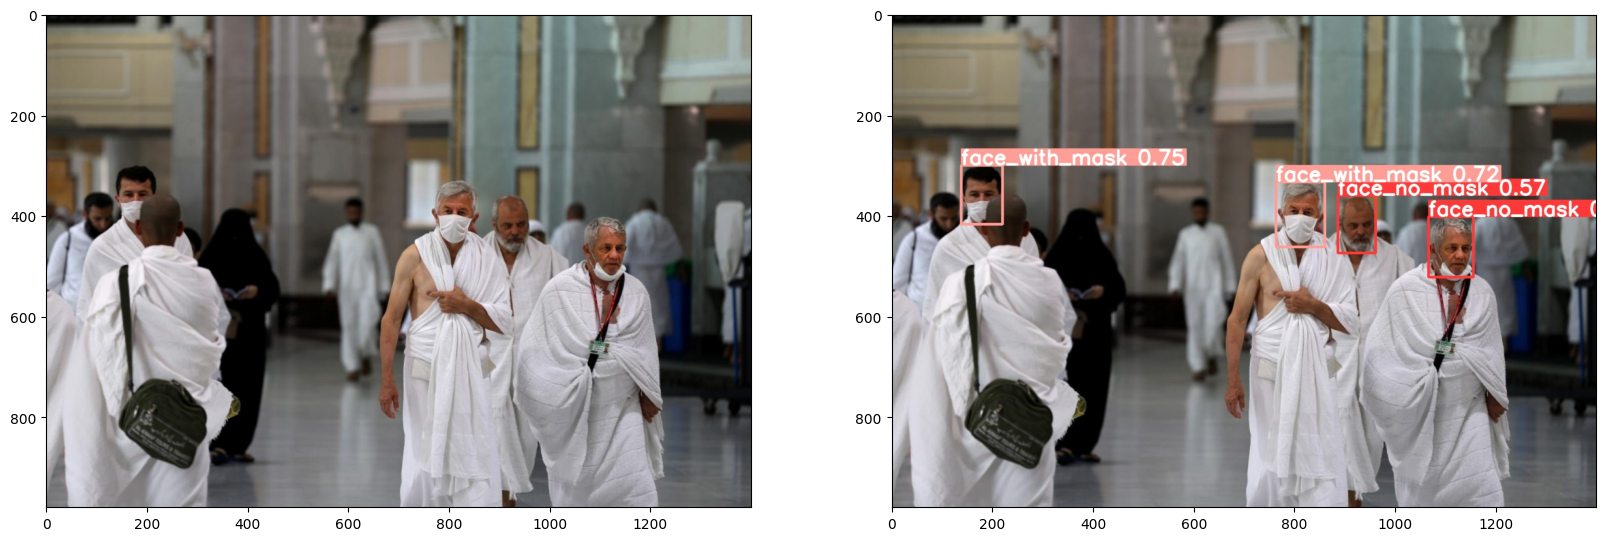

In [18]:
fig,ax = plt.subplots(1,2, figsize = (20,20))

ax[0].imshow(Image.open('/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/0012.jpg'))
ax[1].imshow(Image.open('/kaggle/working/runs/detect/train2/0012.jpg'))

# **Preparing submission.csv**

In [19]:
submit = pd.read_csv('/kaggle/input/face-mask-dataset-wobot/archive/submission.csv')
submit

name  x1  x2  y1  y2  classname
0     1800.jpg NaN NaN NaN NaN        NaN
1     1800.jpg NaN NaN NaN NaN        NaN
2     1800.jpg NaN NaN NaN NaN        NaN
3     1799.jpg NaN NaN NaN NaN        NaN
4     1799.jpg NaN NaN NaN NaN        NaN
...        ...  ..  ..  ..  ..        ...
8137  0003.jpg NaN NaN NaN NaN        NaN
8138  0002.png NaN NaN NaN NaN        NaN
8139  0001.jpg NaN NaN NaN NaN        NaN
8140  0001.jpg NaN NaN NaN NaN        NaN
8141  0001.jpg NaN NaN NaN NaN        NaN

[8142 rows x 6 columns]

In [20]:
res[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 0., 0.], device='cuda:0')
conf: tensor([0.7496, 0.7221, 0.6448, 0.5747], device='cuda:0')
data: tensor([[1.3776e+02, 3.0018e+02, 2.1948e+02, 4.1742e+02, 7.4965e-01, 1.0000e+00],
        [7.6245e+02, 3.3318e+02, 8.5975e+02, 4.6250e+02, 7.2210e-01, 1.0000e+00],
        [1.0657e+03, 4.0224e+02, 1.1549e+03, 5.2284e+02, 6.4478e-01, 0.0000e+00],
        [8.8517e+02, 3.6014e+02, 9.6038e+02, 4.7470e+02, 5.7465e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (979, 1400)
shape: torch.Size([4, 6])
xywh: tensor([[ 178.6244,  358.8039,   81.7190,  117.2397],
        [ 811.0955,  397.8359,   97.2994,  129.3189],
        [1110.2754,  462.5429,   89.1927,  120.6025],
        [ 922.7769,  417.4211,   75.2141,  114.5672]], device='cuda:0')
xywhn: tensor([[0.1276, 0.3665, 0.0584, 0.1198],
        [0.5794, 0.4064, 0.0695, 0.1321],
        [0.7931, 0.4725, 0.0637, 0.1232],
        [0.6591, 0.4264, 0.0537

In [21]:
dir = "/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/"
path_list = list(dir + submit["name"].unique())
path_list[0:5]

['/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1800.jpg',
 '/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1799.jpg',
 '/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1797.jpg',
 '/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1796.jpg',
 '/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1795.jpg']

In [22]:
submission = {"name" : [], "x1" : [], "y1": [], "x2": [], "y2": [], "class_id" : []}
submission = pd.DataFrame(submission)
submission

Empty DataFrame
Columns: [name, x1, y1, x2, y2, class_id]
Index: []

In [ ]:
def fill_data_frame(name, index):
    for i in range(len(classes[index])):
        class_id = classes[index].cpu().numpy()[i]
        coordinates = xyxy[index].cpu().numpy()[i]
        submission.loc[len(submission)] = [name, coordinates[0], coordinates[1], coordinates[2], coordinates[3], class_id]

names = list(submit["name"].unique())
classes = [model.predict(path)[0].boxes.cls for path in path_list]
xyxy = [model.predict(path)[0].boxes.xyxy for path in path_list]

index = 0
for name in names:
    fill_data_frame(name, index)
    index += 1


image 1/1 /kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1800.jpg: 448x640 1 face_no_mask, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1799.jpg: 448x640 3 face_with_masks, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1797.jpg: 448x640 1 face_with_mask, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/1796.jpg: 448x640 1 face_no_mask, 2 face_with_masks, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/i

In [25]:
submission

name           x1          y1           x2           y2  class_id
0     1800.jpg   933.525513  225.430496  1508.345947   817.571167       0.0
1     1799.jpg   686.662415  219.466904   845.795166   410.378693       1.0
2     1799.jpg   232.976273  217.048096   493.606659   542.479675       1.0
3     1799.jpg   892.487610   73.167488  1030.888062   244.091400       1.0
4     1797.jpg   736.047424  103.744995  1284.723267   930.012268       1.0
...        ...          ...         ...          ...          ...       ...
3682  0005.jpg    84.756599   27.994564   268.894440   295.641052       1.0
3683  0004.jpg   604.146790   68.354202   895.852966   463.790253       1.0
3684  0003.jpg  1214.856689   19.482422  2753.078369  1774.952637       1.0
3685  0002.png   328.913452    0.269832   597.024597   377.748230       0.0
3686  0001.jpg   372.094055    8.199402   867.007629   572.204773       0.0

[3687 rows x 6 columns]

**Let's Visualize result**

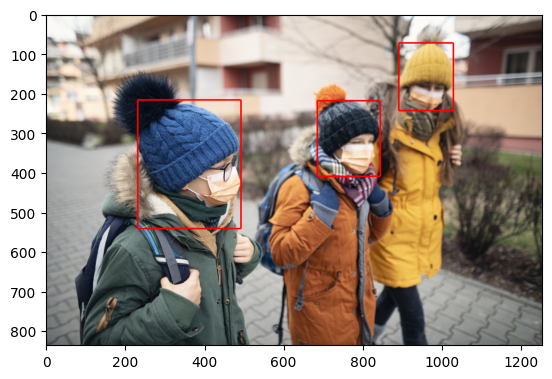

In [26]:
dir = "/kaggle/input/face-mask-dataset-wobot/archive/Medical mask/Medical mask/Medical Mask/images/"

image = np.array(Image.open(dir + '1799.jpg'))
detect_image = draw_bbox(image, int(submission.loc[1]["x1"]), int(submission.iloc[1]["y1"]), int(submission.iloc[1]["x2"]), int(submission.iloc[1]["y2"]))
detect_image = draw_bbox(detect_image, int(submission.loc[2]["x1"]), int(submission.iloc[2]["y1"]), int(submission.iloc[2]["x2"]), int(submission.iloc[2]["y2"]))
detect_image = draw_bbox(detect_image, int(submission.loc[3]["x1"]), int(submission.iloc[3]["y1"]), int(submission.iloc[3]["x2"]), int(submission.iloc[3]["y2"]))

plt.imshow(detect_image)

In [27]:
submission.to_csv('submission.csv', index=False)  
shutil.make_archive('model_weights_&_results','zip','/kaggle/working/runs')

'/kaggle/working/model_weights_&_results.zip'